In [1]:
import reporter.core.requester as req
import reporter.generator as gen
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

import csv
import re

%matplotlib inline

querys = {}

querys['licenseDistInd'] = "\
    SELECT \
        ?license \
        (count(?x) as ?count) \
        { \
            ?x okh:spdxLicense ?licenseUri . \
            { ?x okh:repoHost '%s'. } \
            BIND(REPLACE(STR(?licenseUri), 'https://spdx.org/licenses/', '') \
                AS ?license) \
        } \
    GROUP BY \
        ?license"

querys['licenseDistIndNew'] = "\
    SELECT \
        ?license \
        (count(?x) as ?count) \
        { \
            ?x okh:spdxLicense ?licenseUri . \
            BIND(REPLACE(STR(?licenseUri), 'https://spdx.org/licenses/', '') \
                AS ?license) \
        } \
    GROUP BY \
        ?license \
    ORDER BY \
        DESC(?count)"

querys['repoHosts'] = "\
    SELECT \
        ( \
            REPLACE( \
                REPLACE( \
                    REPLACE( \
                        STR(?repoHostFull), \
                        '^(www|certification|source|en)[.]', \
                        ''), \
                    '[.](com|org|wiki)$', \
                    ''), \
                '^field-ready-projects.openknowhow$', \
                'field-ready') \
            AS ?repoHost \
        ) \
        ?count \
        (round((?count / ?count_all) * 100) AS ?percent) \
    WHERE \
        { \
            { \
                SELECT ?repoHostFull (count(?px) AS ?count) \
                WHERE \
                    { \
                        ?px okh:repoHost ?repoHostFull \
                    } \
                GROUP BY ?repoHostFull \
            } \
            { \
                SELECT (count(?x) AS ?count_all) \
                WHERE \
                    { \
                        ?x okh:repoHost ?repoHostFull \
                    } \
            } \
        } \
    GROUP BY \
        ?count \
        ?count_all \
        ?repoHostFull"

querys['licensesReciprocality'] = "\
    SELECT \
        (count(?x) as ?count) \
        ?reType \
    WHERE \
        { \
            ?x okh:spdxLicense ?license ; \
            okh:spdxLicense ?id . \
            values (?id ?reType) \
            { \
                (<https://spdx.org/licenses/Apache-1.0> \"non\") \
                (<https://spdx.org/licenses/Apache-1.1> \"non\") \
                (<https://spdx.org/licenses/Apache-2.0> \"non\") \
                (<https://spdx.org/licenses/BSD-1-Clause> \"non\") \
                (<https://spdx.org/licenses/BSD-2-Clause> \"non\") \
                (<https://spdx.org/licenses/BSD-2-Clause-Paten> \"non\") \
                (<https://spdx.org/licenses/BSD-3-Clause> \"non\") \
                (<https://spdx.org/licenses/BSD-3-Clause-Clear> \"non\") \
                (<https://spdx.org/licenses/BSD-3-Clause-LBNL> \"non\") \
                (<https://spdx.org/licenses/BSD-4-Clause> \"non\") \
                (<https://spdx.org/licenses/MIT> \"non\") \
                (<https://spdx.org/licenses/MIT-0> \"non\") \
                (<https://spdx.org/licenses/CC-BY-1.0> \"non\") \
                (<https://spdx.org/licenses/CC-BY-2.0> \"non\") \
                (<https://spdx.org/licenses/CC-BY-2.5> \"non\") \
                (<https://spdx.org/licenses/CC-BY-2.5-AU> \"non\") \
                (<https://spdx.org/licenses/CC-BY-3.0-AT> \"non\") \
                (<https://spdx.org/licenses/CC-BY-3.0-DE> \"non\") \
                (<https://spdx.org/licenses/CC-BY-3.0-NL> \"non\") \
                (<https://spdx.org/licenses/CC-BY-3.0-US> \"non\") \
                (<https://spdx.org/licenses/CC-BY-3.0> \"non\") \
                (<https://spdx.org/licenses/CC-BY-4.0> \"non\") \
                (<https://spdx.org/licenses/CC-BY-SA-1.0> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-2.0> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-2.0-UK> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-2.1-JP> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-2.5> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-3.0> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-3.0-AT> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-3.0-DE> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-4.0> \"strong\") \
                (<https://spdx.org/licenses/CC0-1.0> \"non\") \
                (<https://spdx.org/licenses/CERN-OHL-1.1> \"strong\") \
                (<https://spdx.org/licenses/CERN-OHL-1.2> \"strong\") \
                (<https://spdx.org/licenses/CERN-OHL-P-2.0> \"non\") \
                (<https://spdx.org/licenses/CERN-OHL-S-2.0> \"strong\") \
                (<https://spdx.org/licenses/CERN-OHL-W-2.0> \"weak\") \
                (<https://spdx.org/licenses/GPL-1.0-only> \"strong\") \
                (<https://spdx.org/licenses/GPL-1.0-or-later> \"strong\") \
                (<https://spdx.org/licenses/GPL-2.0-only> \"strong\") \
                (<https://spdx.org/licenses/GPL-2.0-or-later> \"strong\") \
                (<https://spdx.org/licenses/GPL-3.0> \"strong\") \
                (<https://spdx.org/licenses/GPL-3.0-or-later> \"strong\") \
                (<https://spdx.org/licenses/SHL-0.5> \"non\") \
                (<https://spdx.org/licenses/SHL-0.51> \"non\") \
                (<https://spdx.org/licenses/SHL-2.0> \"non\") \
                (<https://spdx.org/licenses/SHL-2.1> \"non\") \
                (<https://spdx.org/licenses/TAPR-OHL-1.0> \"strong\") \
                (<https://spdx.org/licenses/N/A> \"N/A\") \
            } \
        } \
    GROUP BY \
        ?reType"

querys['projectInputMethod'] = "\
    SELECT \
        ?uploadMethod \
        (count(?x) AS ?count) \
    WHERE \
        { ?x okh:uploadMethod ?uploadMethod } \
    GROUP BY \
        ?uploadMethod"

querys['otrl'] = "\
    SELECT \
        (REPLACE(STR(?otrlUri), '^http://purl.org/oseg/ontologies/OTRL#', '') \
            AS ?otrl) \
        (count(?x) AS ?count) \
    WHERE \
        { ?x okh:technologyReadinessLevel ?otrlUri } \
    GROUP BY \
        ?otrlUri"

querys['odrl'] = "\
    SELECT \
        (REPLACE(STR(?odrlUri), '^http://purl.org/oseg/ontologies/OTRL#', '') \
            AS ?odrl) \
        (count(?x) AS ?count) \
    WHERE \
        { ?x okh:documentationReadinessLevel ?odrlUri } \
    GROUP BY \
        ?odrlUri"

querys['cpc'] = "\
    SELECT \
        ( \
            REPLACE( \
                STR(?cpc_full), \
                '^(.).+', \
                '$1') \
            AS ?cpc_main \
        ) \
        ( \
            REPLACE( \
                STR(?cpc_full), \
                '^.(.{0,2}).*', \
                '$1') \
            AS ?cpc_sub \
        ) \
        (count(?x) AS ?count) \
        (round((?count / ?count_all) * 100) AS ?percent) \
    WHERE \
        { ?x okh:cpcPatentClass ?cpc_full } \
    GROUP BY \
        ?cpc_main \
        ?cpc_short \
        ?cpc_full \
        ?count_all"

querys['countAll'] = "\
    SELECT \
        (count(?x) AS ?count) \
        { ?x rdf:type okh:Module }"

result_data = {}
for query_name, query in querys.items():
    results = req.request(query)
    result_data[query_name] = list(map(gen.map_result, results))
    
num_all_projects = result_data["countAll"][0]["count"]

def fetch_xy(x_selector="repoHosts.repoHost", y_selector="repoHosts.count"):
    fig_options = {}
    fig_options["x"] = x_selector
    fig_options["y"] = y_selector

    fig_options["x"] = fig_options["x"].split('.')
    fig_options["y"] = fig_options["y"].split('.')

    x_values = [d[fig_options["x"][1]] for d in result_data[fig_options["x"][0]]]
    y_values = [d[fig_options["y"][1]] for d in result_data[fig_options["y"][0]]]

    return x_values, y_values

def accum_below_abs(x_values, y_values, limit):
    accum = 0
    y_i = 0
    y_len = len(y)
    while y_i < y_len:
        if y_values[y_i] < limit:
            accum += y_values[y_i]
            x_values.pop(y_i)
            y_values.pop(y_i)
            # y_values = y_values[:y_i] + [sum(y_values[y_i:])]
            y_len -= 1
        else:
            y_i += 1

    if accum > 0:
        x_values = x_values + ['Misc.']
        y_values = y_values + [accum]

    return x_values, y_values

def accum_below_frac(x_values, y_values, limit_frac):
    y_total = float(sum(y_values))
    limit = int(limit_frac * y_total)
    return accum_below_abs(x_values, y_values, limit)

def piechart_create(x, y, title="repo-hosts", label="count", acc_frac=None, legend_vals=False):
    y_total = float(sum(y))
    
    if legend_vals:
        for y_i in range(len(y)):
            frac = y[y_i] / y_total
            x[y_i] = ('%4.1f%% (%8d) ' % (frac * 100, y[y_i])) + x[y_i]

    plt.rcParams["figure.figsize"] = (10,3)
    plt.rcParams.update({'font.family': 'monospace'})

    fig, ax = plt.subplots()
    ax.pie(y,
        # autopct='%1.1f%%',
        pctdistance=1.14,
        radius = 0.8,
        wedgeprops = {'linewidth': 0.5, 'edgecolor':'k'}
        )
    plt.legend(x, bbox_to_anchor=(1,0), loc='lower right',
        bbox_transform=plt.gcf().transFigure)
    ax.set_title(title)
    fig.set_dpi(200)
    
    return fig, ax

def barchart_create(x, y, title="repo-hosts", label="count"):
    plt.rcParams["figure.figsize"] = (10,7)

    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(title, fontsize=12)
    plt.ylabel(label, fontsize=12)
    fig.set_dpi(200)
    
    return fig, ax

# function to add value labels
def barchart_add_labels(x, y, is_log = False):
    for i in range(len(x)):
        display_height = y[i]
        plt.text(i, display_height, y[i], ha = 'center', bbox = dict(facecolor = 'white', alpha = .5))

<!--
---
title: LOSH Data Report
subtitle: |
          | Annual, mostly statistical report on Open Source Hardware based on data from the LOSH knowledge base
          | **${PROJECT_VERSION_DATE}**
          | *version:* [${PROJECT_VERSION}](${PROJECT_VERSION_URL})
version: "${PROJECT_VERSION}"
date: "${PROJECT_VERSION_DATE}"
lang: en-US
charset: UTF-8
license: CC-BY-4.0
keywords:
- Open Source Hardware
- LOSH
- OSHdata
papersize: a4
geometry: "top=2cm,bottom=2cm,left=3cm,right=3cm"
comment: license applies to generated reports; date is automatically generated
...
-->

# Intro

## General

<!-- TODO Moe general info about LOSH to be added -->

Efforts partly merged with the [OSHdata project](oshdata.com), which published annually reports based on data crawled from the [list of OSHWA-certified OSH projects](https://certification.oshwa.org/list.html). Since OSHWA published [its API](https://certificationapi.oshwa.org/documentation), no crawling is needed anymore. And since LOSH is here to collect data also from other platforms, we decided to take care of regular OSHdata reports – now also including data from other platforms.

Generally, all data you will find here is also publicly available in the LOSH knowledge base. This report is generated using the [LOSH-Reporter](https://github.com/OPEN-NEXT/LOSH-Reporter/) tool (GPL-3.0-OR-LATER). All we do is running a bunch of pre-defined queries on LOSH's knowledge base using that tool. If you want to look into the raw data yourself, e.g. to run some self-defined queries, find it [here](https://gitlab.opensourceecology.de/verein/projekte/losh-rdf) ([CC0-1.0](https://gitlab.opensourceecology.de/verein/projekte/losh-rdf/-/blob/main/LICENSE)). The report you are reading is licensed under the Creative Commons Attribution 4.0 International License ([CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/legalcode)). This license covers the entire report, including the text and graphics. OSHdata is a project of the [Open Hardware Observatory e.V. (non-profit)](https://en.oho.wiki/wiki/Imprint) since 2021 (before is was a project of Kenny Consulting Group, LLC).

## Scope

<!--- TODO Moe brief description of scope to be added -->

## Get in contact with us

OSHdata is hosted by the [Open Hardware Repository e.V. (non-profit)](http://oho.wiki/) since 2021. Feel free to reach out to Robert to get in touch: [rm@oho.wiki](mailto:rm@oho.wiki?cc=mh@oho.wiki&subject=from%20the%20LOSH%20report)

LOSH was started inside the EU-H2020-founded [OPEN_NEXT](https://opennext.eu/) project back in 2020 and is hosted and maintained by [Open Source Ecology Germany e.V. (non-profit)](https://ose-germany.de/) since 2022. You can reach these folks via eMail ([verein@ose-germany.de](mailto:verein@ose-germany.de?cc=martin.haeuer@ose-germany.de&subject=from%20the%20LOSH%20report)) or Telegram ([@OSEGWelcome](https://t.me/OSEGWelcome)) – don't be shy; looking forward to e-meet you :)

You can also sign up for our [newsletter](TODO Moe) or follow us on Twitter via [@OSHdata](https://twitter.com/OSHdata).

## This report…

<!--- TODO Moe brief intro specific to this version of the report to be added -->

[[TOC]]

# Highlighted Projects

TODO Moe OSH flagship projects

2…4 projects from OSEG-CAB & OHO-CAB to be briefly presented & promoted

<!--- TODO Moe 2021: MNT Reform, OpenFlexure; something from OHO -->

# LOSH Data

## Introduction

Currently, LOSH collects data from the following platforms:

- [GitHub.com](http://github.com/)
- [Wikifactory.com](https://wikifactory.com/)
- [OSHWA Certification List](https://certification.oshwa.org/list.html)
- [Thingiverse.com](https://www.thingiverse.com/)

Additionally we have scripts catching data from:

- [Appropedia.org](https://appropedia.org/)
- [Open Know-How](https://openknowhow.org/) (including e.g. [Fieldready.org](https://www.fieldready.org/))

and making it available via GitHub:

- original TOML manifests in the [LOSH-list](https://github.com/OPEN-NEXT/LOSH-list/)
- cleaned-up TOML manifests and their RDF representation as Turtle files
  in [losh-rdf](https://gitlab.opensourceecology.de/verein/projekte/losh-rdf/)

The minimum threshold for LOSH to be recognised as an OSH project is to have:

- a free/open license,
- a README file and
- at least one source file (other than the README.md, CONTRIBUTING.md or an image).

<!--- TODO Moe add short description of upload methods (copy from D3.4 + D3.3 report) -->

## Data Sources

### Current Data

By the publishing date of this report, the LOSH knowledge base contains:

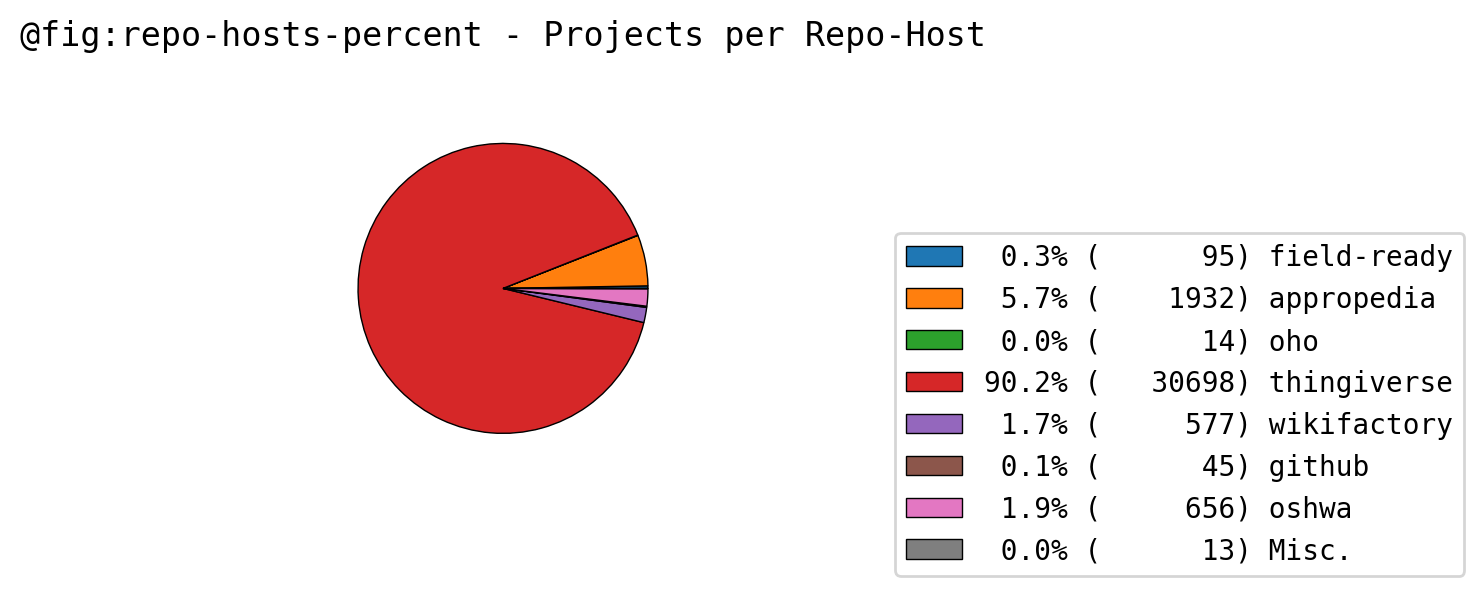

In [2]:
# We had such a table0-like list in the past, but it is much better and more easily visualized in the pie-chart below

# - {ghproj} from [GitHub.com](http://github.com/) (not counting Open Know-How or Appropedia.org) ({} % of all its projects)
# - {gltotalproj} from gitlab-based platforms ({} % of all its projects) <!---NOTE: gitlab-based repo hosts are listed in specs/gitlab-platforms.csv -->
# - {wifproj} from [Wikifactory.com](https://wikifactory.com/) ({} % of all its projects)
# - {oshwaproj} from [OSHWA Certification List](https://certification.oshwa.org/list.html) ({} % of all its projects)
# - {thingiproj} from [Thingiverse.com](https://www.thingiverse.com/) ({} % of all its projects)
# - {approproj} from [Appropedia.org](https://appropedia.org/) ({} % of all its projects)
# - {okhproj} from [Open Know-How](https://openknowhow.org/) ({} % of all its projects)
# - {otherproj} from diverse other sources ({} % of all its projects)

# templater.get_value(repoHosts,{"repoHost": "github.com"}, "count")} from [GitHub.com](http://github.com/) (not counting Open Know-How or Appropedia.org) (${get_value(repoHosts, {"repoHost": "github.com"}, "percent")} % of all its projects)
# - ${get_value(repoHosts,{"repoHost": "gitlab.com"}, "count")} from [GitLab.com](http://gitlab.com/) (not counting Open Know-How or Appropedia.org) (${get_value(repoHosts, {"repoHost": "gitlab.com"}, "percent")} % of all its projects)
# - ${get_value(repoHosts,{"repoHost": "source.mnt.re"}, "count")} from [source.mnt.re](https://source.mnt.re) (${get_value(repoHosts, {"repoHost": "source.mnt.re"}, "percent")} % of all its projects)
# - ${get_value(repoHosts,{"repoHost": "wikifactory.com"}, "count")} from [Wikifactory.com](https://wikifactory.com/) (${get_value(repoHosts, {"repoHost": "wikifactory.com"}, "percent")} % of all its projects)
# - ${get_value(repoHosts,{"repoHost": "certification.oshwa.org"}, "count")} from [OSHWA Certification List](https://certification.oshwa.org/list.html) (${get_value(repoHosts, {"repoHost": "certification.oshwa.org"}, "percent")} % of all its projects)
# - ${get_value(repoHosts,{"repoHost": "en.oho.wiki"}, "count")} from [Open Hardware Observatory](https://en.oho.wiki) (${get_value(repoHosts, {"repoHost": "en.oho.wiki"}, "percent")} % of all its projects)
# - ${get_value(repoHosts, {"repoHost": "www.thingiverse.com"}, "count")} from [Thingiverse.com](https://www.thingiverse.com/) (${get_value(repoHosts, {"repoHost": "www.thingiverse.com"}, "percent")} % of all its projects)

x_selector="repoHosts.repoHost"
y_selector="repoHosts.count"
acc = 5
x, y = fetch_xy(x_selector, y_selector)
x, y = accum_below_abs(x, y, acc)
fig_01, ax_01 = piechart_create(
    x,
    y,
    title="@fig:repo-hosts-percent - Projects per Repo-Host",
    label="repo-host",
    legend_vals=True)

<!--
…as illustrated in @fig:data-input-count, totalling data from our platforms.
According to how LOSH works, this equals {{data_source_count}} different data sources.
-->

<!-- ??? NOTE: the list there is, what from here on is abbreviated as {platforms} ??? -->

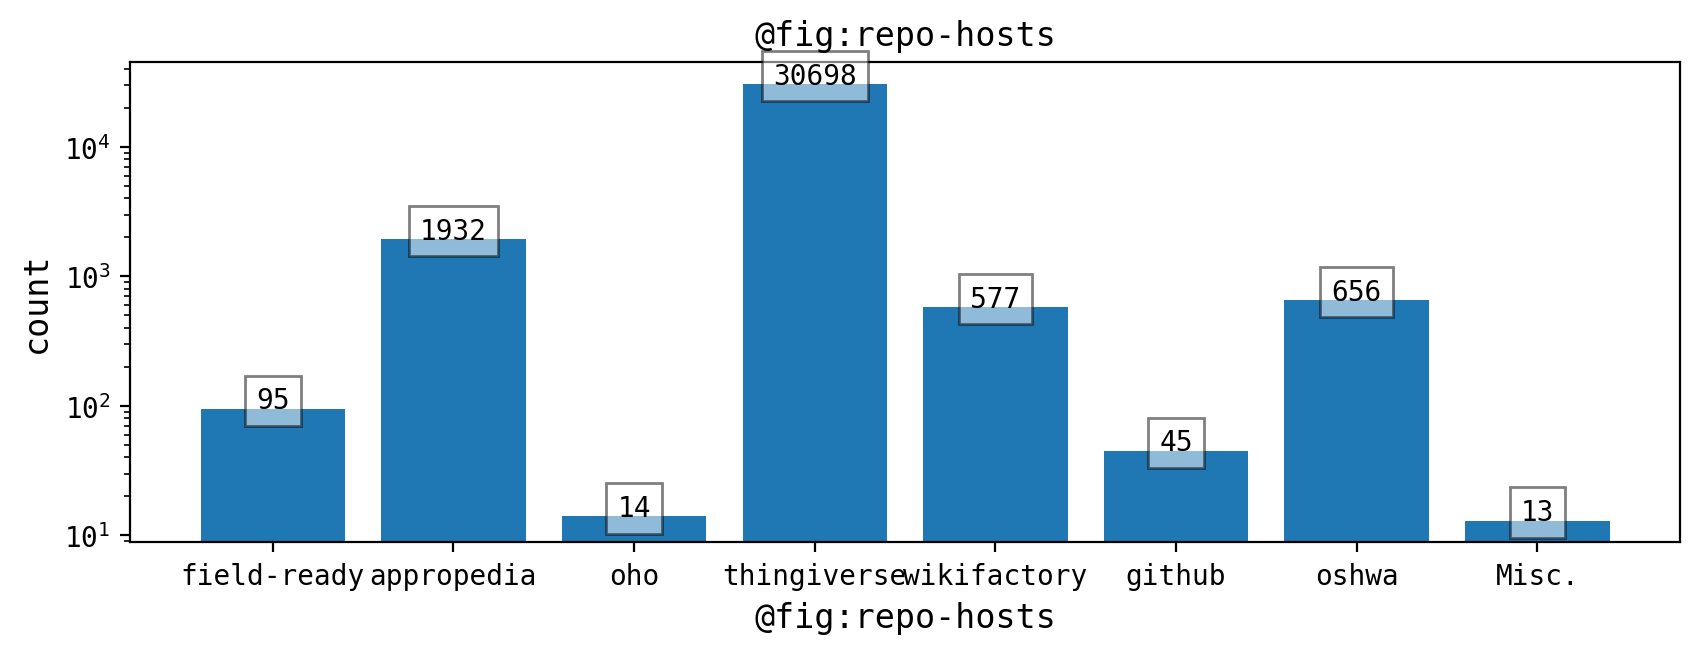

In [3]:
# a bar chart with the above mentioned values, each bar splitting into accepted and rejected projects (rejected projects on top)
x_selector="repoHosts.repoHost"
y_selector="repoHosts.count"
acc = 5
x, y = fetch_xy(x_selector, y_selector)
x, y = accum_below_abs(x, y, acc)
fig, ax = barchart_create(x, y, title="@fig:repo-hosts", label="count")
ax.set_yscale('log')
barchart_add_labels(x, y)

@fig:input-method-dist shows the distribution of upload methods that have been used for this data set.

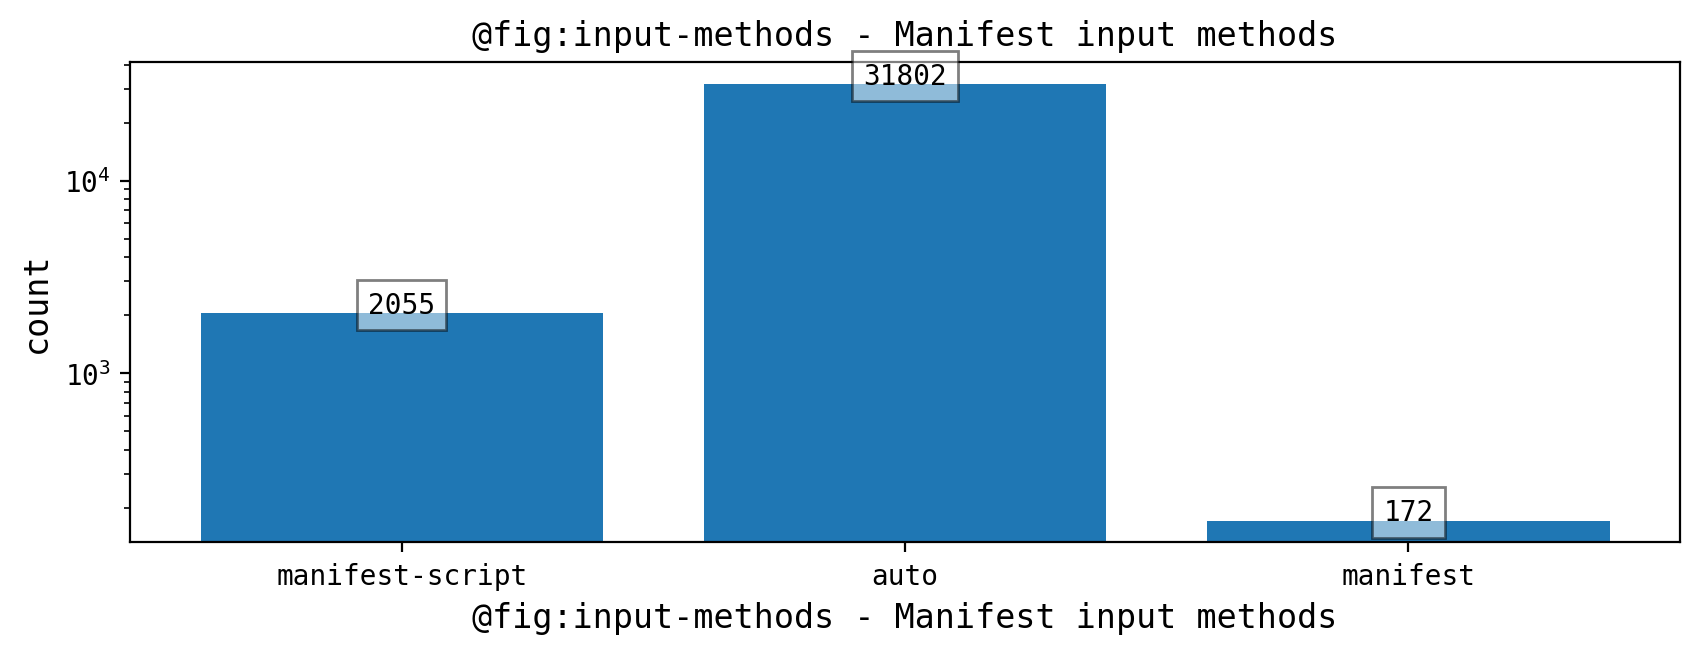

In [4]:
# bar chart showing the distribution of uploading methods used for LOSH (auto, manifest, manifest-script, manual)
x_selector="projectInputMethod.uploadMethod"
y_selector="projectInputMethod.count"
x, y = fetch_xy(x_selector, y_selector)
fig, ax = barchart_create(x, y, title="@fig:input-methods - Manifest input methods", label="count")
ax.set_yscale('log')
barchart_add_labels(x, y)

### History

This is the very first of the LOSH Reports. :-)

<!--
Since the first report, published back in February 2022, data input has developed as following:

TODO Robin (NO-CAN-DO: No registration-time data) combined historical line diagram of total count of projects per year & for each {platform}

Looking into the recent past @fig:data-hist-grow2 shows the grow rates for the past two years.

TODO Robin (NO-CAN-DO: No registration-time data) horizontal bar chart with grow rates per {platform} per each of the past 2 years + a bar for the total grow rate
{#fig:data-hist-grow2}
-->

## Licenses

What separates a piece of open source hardware from a proprietary one is primarily its license.

<!-- TODO Moe add more info, also linking the OSH legal issues guideline and the tl;dr -->

<!--
NOTE: We do not have this:
The following @fig:license-dist shows the distribution of licenses under which the _hardware_ has been published per platform.
-->

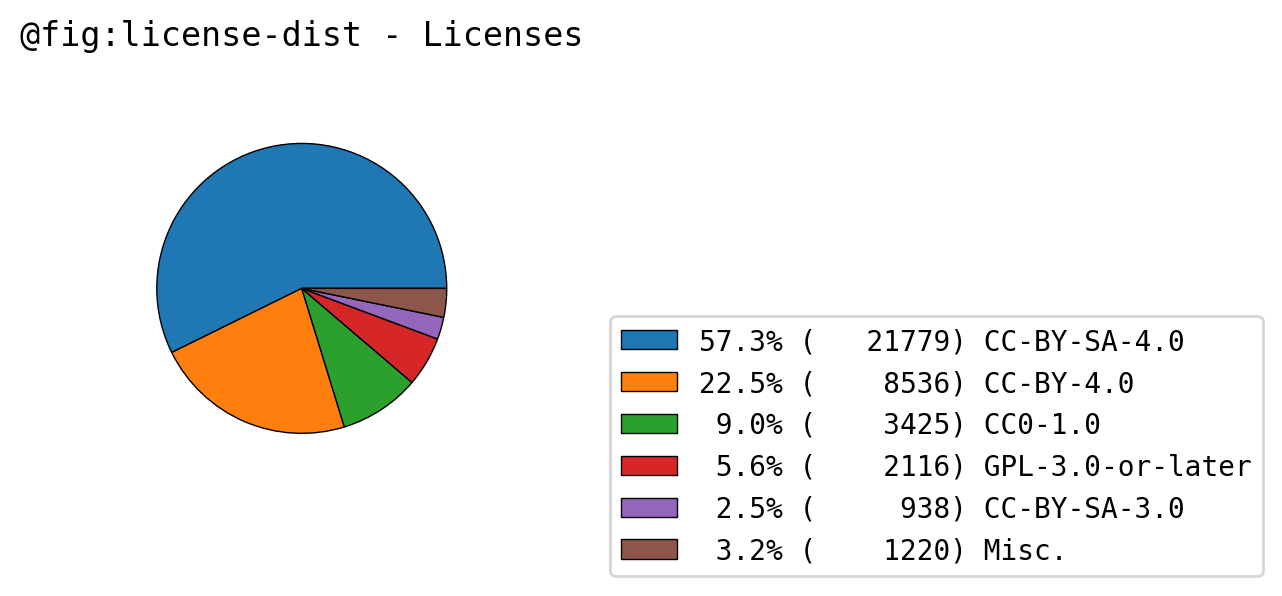

In [5]:
# pie chart showing the distribution of `spdxLicense`
x_selector="licenseDistIndNew.license"
y_selector="licenseDistIndNew.count"
acc_frac=0.01
x, y = fetch_xy(x_selector, y_selector)
x, y = accum_below_frac(x, y, acc_frac)
fig_03, ax_03 = piechart_create(
    x,
    y,
    title="@fig:license-dist - Licenses",
    label="license",
    legend_vals=True)

Totalled, @fig:license-dist is the overall distribution of licenses used by the projects.

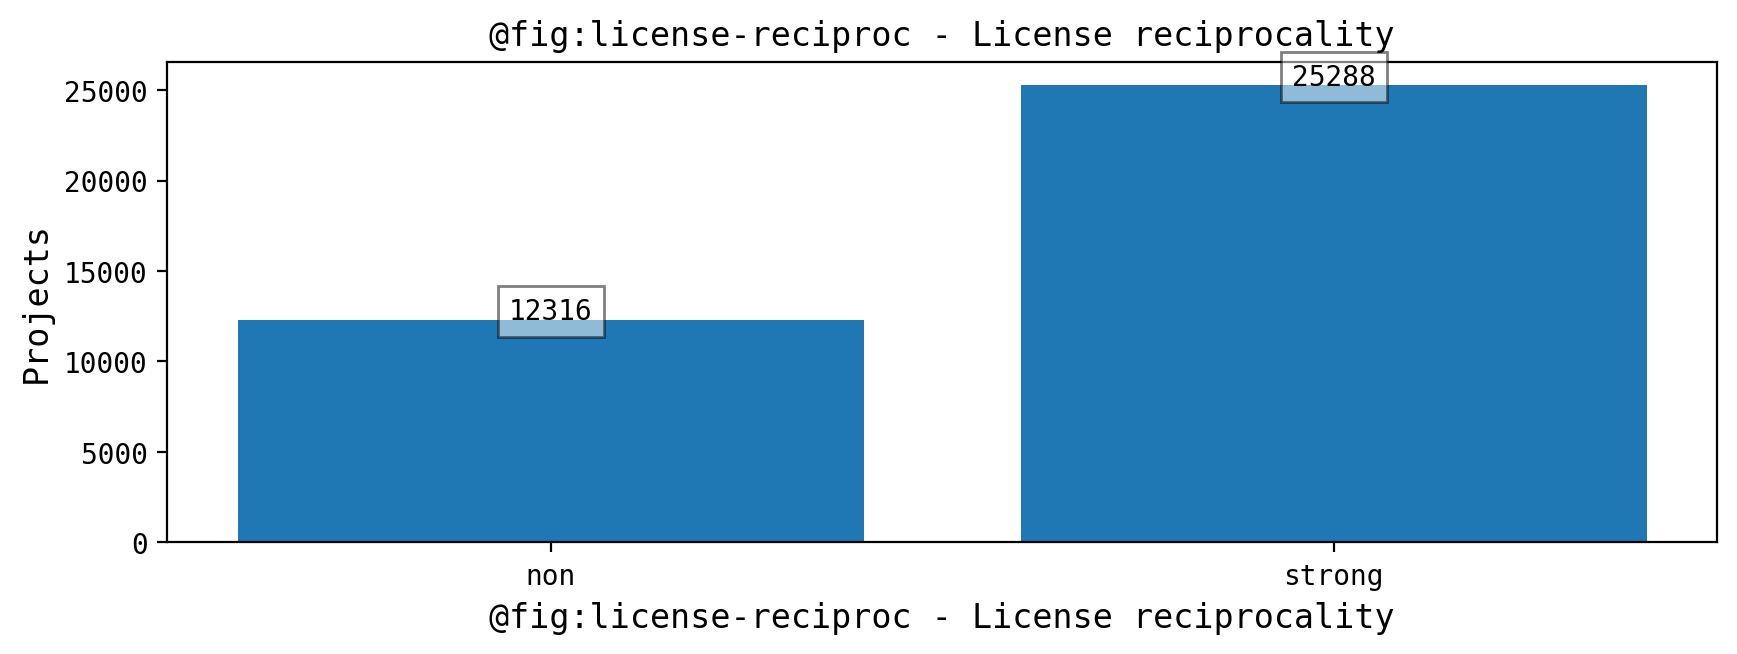

In [6]:
# pie chart showing the overall distribution of `spdxLicense`, sorted by strongly, weakly an non-reciprocal licensing schemes
x_selector="licensesReciprocality.reType"
y_selector="licensesReciprocality.count"
x, y = fetch_xy(x_selector, y_selector)
# fig, ax = barchart_create(x, y, title="reciprocality", label="overall distribution of spdxLicense")
fig, ax = barchart_create(x, y, title="@fig:license-reciproc - License reciprocality", label="Projects")
# ax.set_yscale('log')
barchart_add_labels(x, y)

## Hardware Types

### Open Technology & Documentation Readiness

Open Technology and Documentation Readiness Levels (OTRL, ODRL, as defined in [ref](https://docs.google.com/document/d/1-l6DI91unnAshzjKhjotpAfy_8RsS-9T7YmdYuwL4RI/edit#)) give a good approximation:

1. how mature the hardware design itself is (OTRL) and
2. how mature and open the documentation is (ODRL).

The different levels are:

[copy from publication]

So the two extreme cases would be:

- an OSH design with OTRL-6 and ODRL-1,
  meaning a safe-to-use product that could be circulated on the market,
  but has barely any documentation published appart from a README,
  maybe a few STEP files and bearing a free/open license;
- an OSH design with OTRL-1 and ODRL-4,
  so a design still in the ideation phase,
  but exeptionally well-documented,
  even with documents for a (future) CE-Certification published under a free/open license.

Among the whole knowledge base,
the readiness levels distribute as shown in @fig:otrl-total and @fig:odrl-total

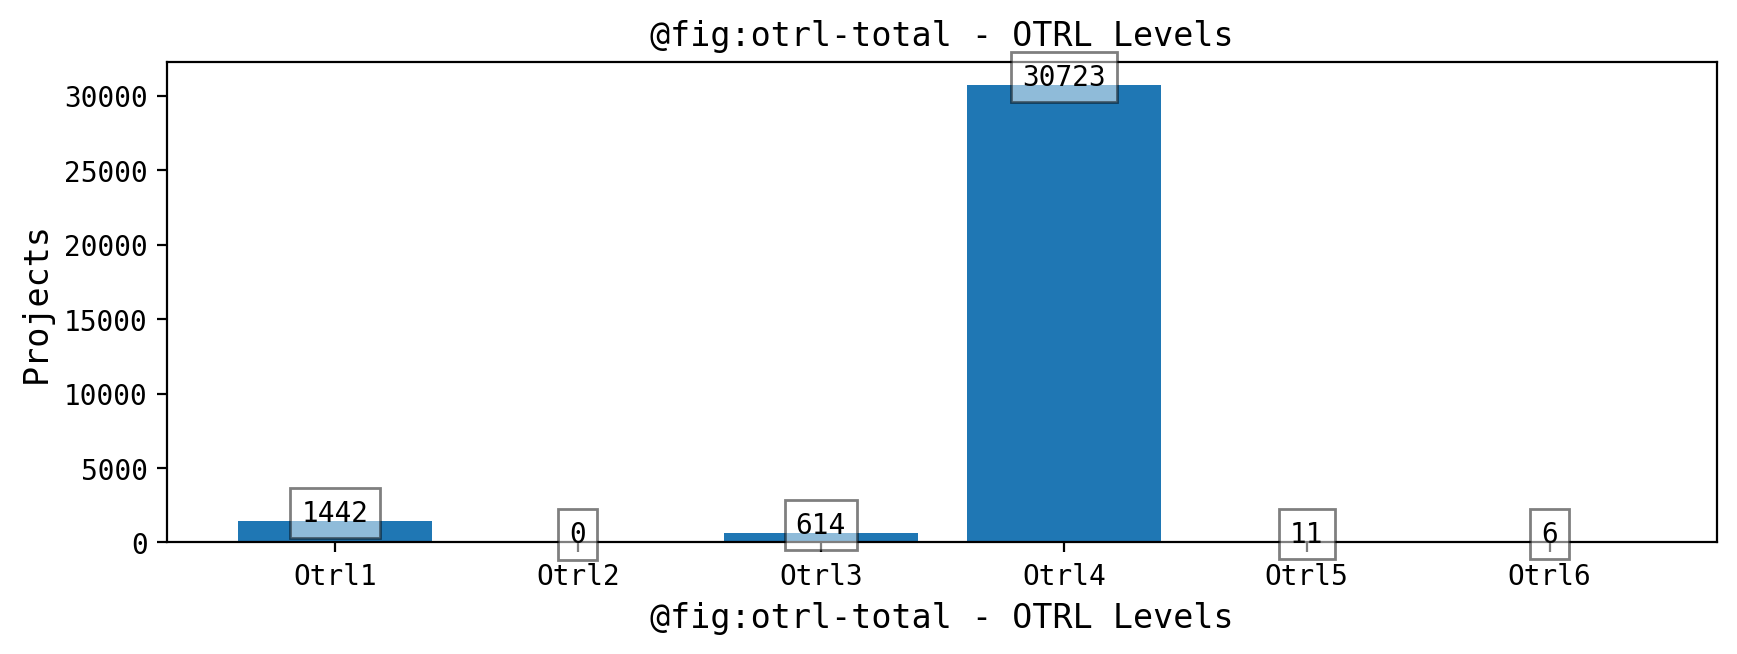

In [7]:
# horizontal stacked bar chart for OTRL levels and (stacked) their distribution among the {platforms}, also include "undefined"
x_selector="otrl.otrl"
y_selector="otrl.count"
otrl_all = ['Otrl1', 'Otrl2', 'Otrl3', 'Otrl4', 'Otrl5', 'Otrl6']
x, y = fetch_xy(x_selector, y_selector)

def fill_with_zero(x, y, all_x):
    tups = zip(x, y)
    tups = sorted(tups)
    non_zero_data = dict(tups)

    x = []
    y = []
    for i in range(len(all_x)):
        x.append(all_x[i])
        y.append(non_zero_data[all_x[i]] if all_x[i] in non_zero_data else 0)

    return x, y

x, y = fill_with_zero(x, y, otrl_all)

fig, ax = barchart_create(
    x, 
    y,
    title="@fig:otrl-total - OTRL Levels",
    label="Projects")
# ax.set_yscale('log')
barchart_add_labels(x, y)

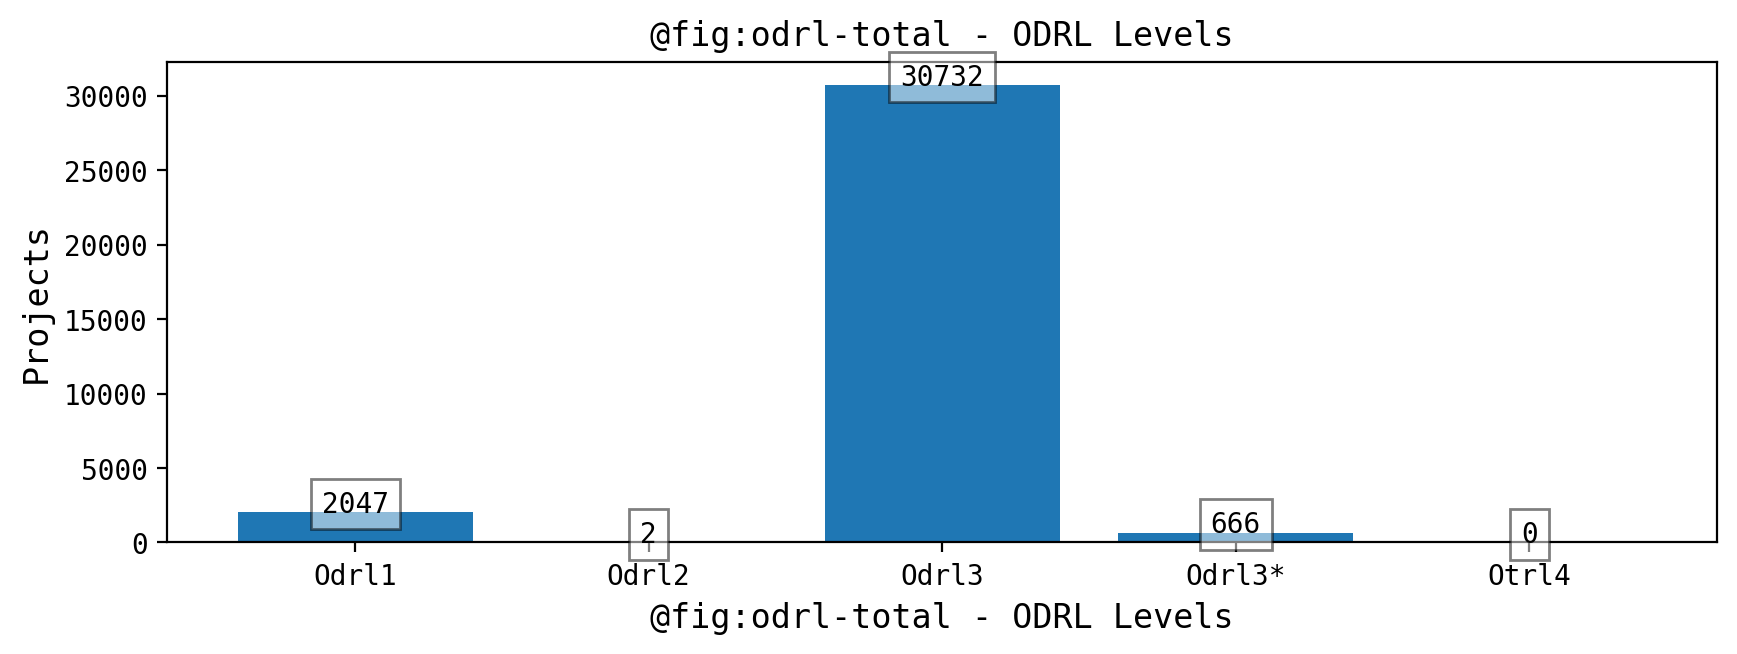

In [8]:
# horizontal stacked bar chart for ODRL levels and (stacked) their distribution among the {platforms}, also include "undefined
x_selector="odrl.odrl"
y_selector="odrl.count"
odrl_all = ['Odrl1', 'Odrl2', 'Odrl3', 'Odrl3*', 'Otrl4']
x, y = fetch_xy(x_selector, y_selector)
x, y = fill_with_zero(x, y, odrl_all)

fig, ax = barchart_create(
    x, 
    y,
    title="@fig:odrl-total - ODRL Levels",
    label="Projects")
# ax.set_yscale('log')
barchart_add_labels(x, y)

<!-- @fig:otrl-odrl-heatmap shows the resulting heatmap for a combination of both scales. -->

In [9]:
# TODO Robin heatmap of all OSH projects with OTRL AND ODRL defined;
# see p. 5 here: https://docs.google.com/document/d/1-l6DI91unnAshzjKhjotpAfy_8RsS-9T7YmdYuwL4RI/edit#
# {#fig:otrl-odrl-heatmap}

### Technology Categories

In [10]:
# stacked bar charts with 1 bar per used first level CPC (F, H etc.) and the next sublevel (e.g. H03) stacked
# For human readability, we want to display the class and sub-class titles.
# We get them from the "CPC Title List" download found on this site:
# https://www.cooperativepatentclassification.org/cpcSchemeAndDefinitions/bulk
# Which at the time of our last download was:
# https://www.cooperativepatentclassification.org/sites/default/files/cpc/bulk/CPCTitleList202205.zip

num_cpc_projects = 0
cpc_mains = dict()
for cpc in result_data["cpc"]:
    main = cpc['cpc_main']
    sub = cpc['cpc_sub']
    count = cpc['count']
    num_cpc_projects += count
    cpc_mains.setdefault(main, {})[sub] = count
cpc_mains
#result_data["cpc"][0]['cpc_main']
#cpc_mains = set(x for result_data["cpc"])
# result_data["cpc"]


cpc_main_letters = [
    'A',
    'B',
    'C',
    'D',
    'E',
    'F',
    'G',
    'H',
    'Y'
]
cpc_main2index = { k: v for v, k in enumerate(cpc_main_letters) }

# A: Human Necessities
# B: Operations and Transport
# C: Chemistry and Metallurgy
# D: Textiles
# E: Fixed Constructions
# F: Mechanical Engineering
# G: Physics
# H: Electricity
# Y: Emerging Cross-Sectional Technologies
cpc_main_colors = [
    'pink', # A: Human Necessities
    'yellow',  # B: Operations and Transport
    'purple', # C: Chemistry and Metallurgy
    'red', # D: Textiles
    '#333333',  # E: Fixed Constructions
    'blue',  # F: Mechanical Engineering
    'green', # G: Physics
    'orange',  # H: Electricity
    '#AAAAAA'   # Y: Emerging Cross-Sectional Technologies
]

cpc_titles = dict()
with open('output/cpc-titles.csv', newline='') as cpc_titles_file:
    cpc_titles_list = csv.reader(cpc_titles_file)
    for cpc_title in cpc_titles_list:
        cpc_titles[cpc_title[0]] = cpc_title[1]
        # print(', '.join(cpc_title))


Classifying hardware by it's technology can be a non-trivial task – every online platform seems to run their own from-scratch-developed category system. LOSH tries to merge some of those category system into a single, established one that has been around for a while: patent classes, specifically the [Cooperative Patent Classification](https://www.epo.org/searching-for-patents/helpful-resources/first-time-here/classification/cpc.html) system (CPC). This may even help patent agents when searching for relevant open source designs (#defensive-publishing).

In [11]:
md("""However, since LOSH can only process data that is provided in the first place,
  patents classes are only available for """
   + str(num_cpc_projects)
   + """ OSH projects (that is """
   + str(round(num_cpc_projects * 100.0 / num_all_projects, 2))
   + """ % of the knowledge base).
   @fig:cpc-total shows the total distribution of top-level CPCs, 
   @tbl:cpc-legend provides the full designation for those IDs.""")

However, since LOSH can only process data that is provided in the first place,
  patents classes are only available for 64 OSH projects (that is 0.19 % of the knowledge base).
   @fig:cpc-total shows the total distribution of top-level CPCs, 
   @tbl:cpc-legend provides the full designation for those IDs.

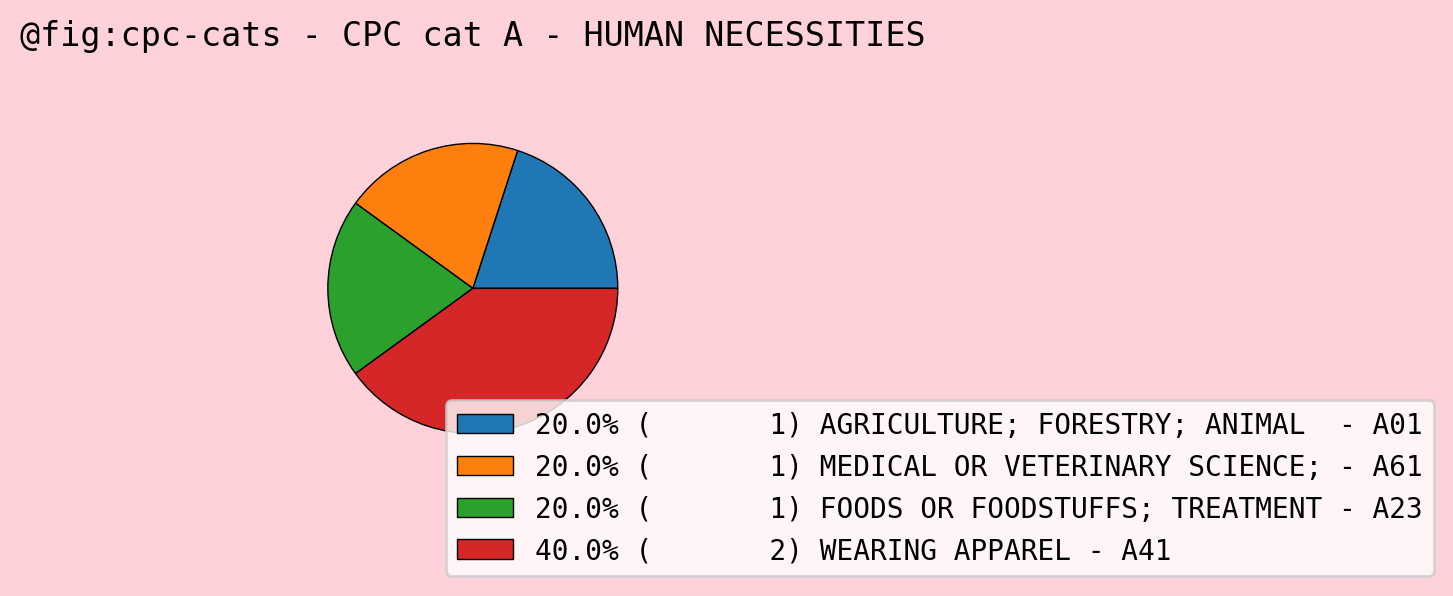

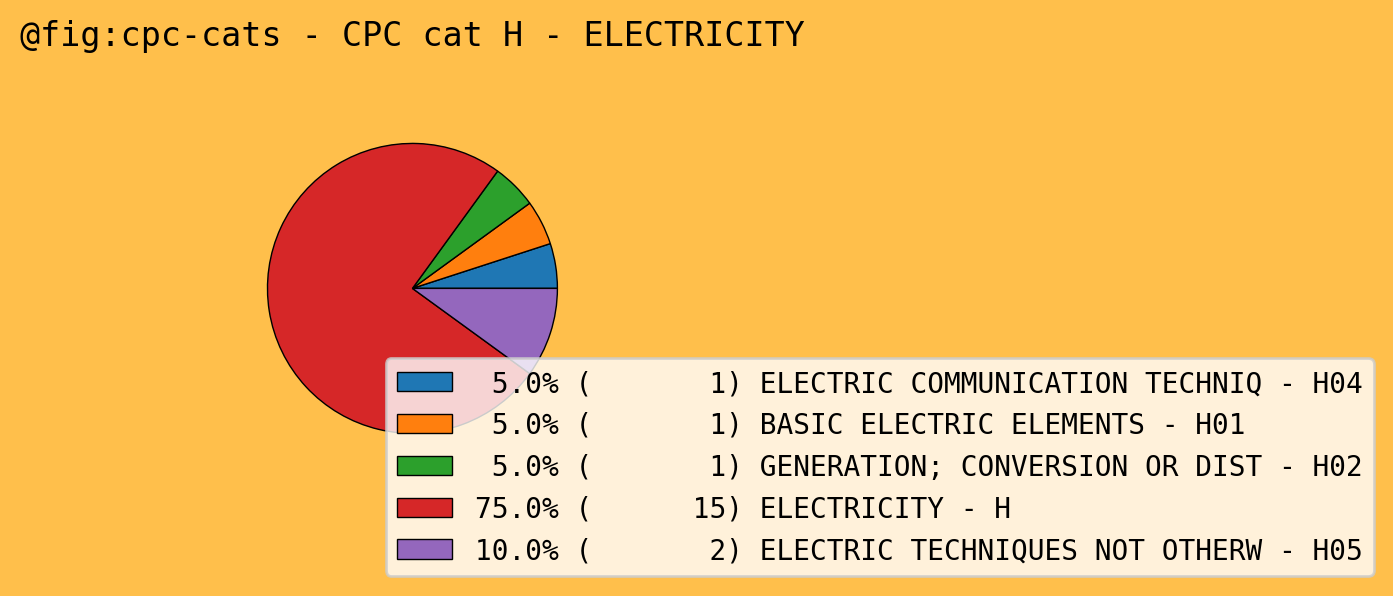

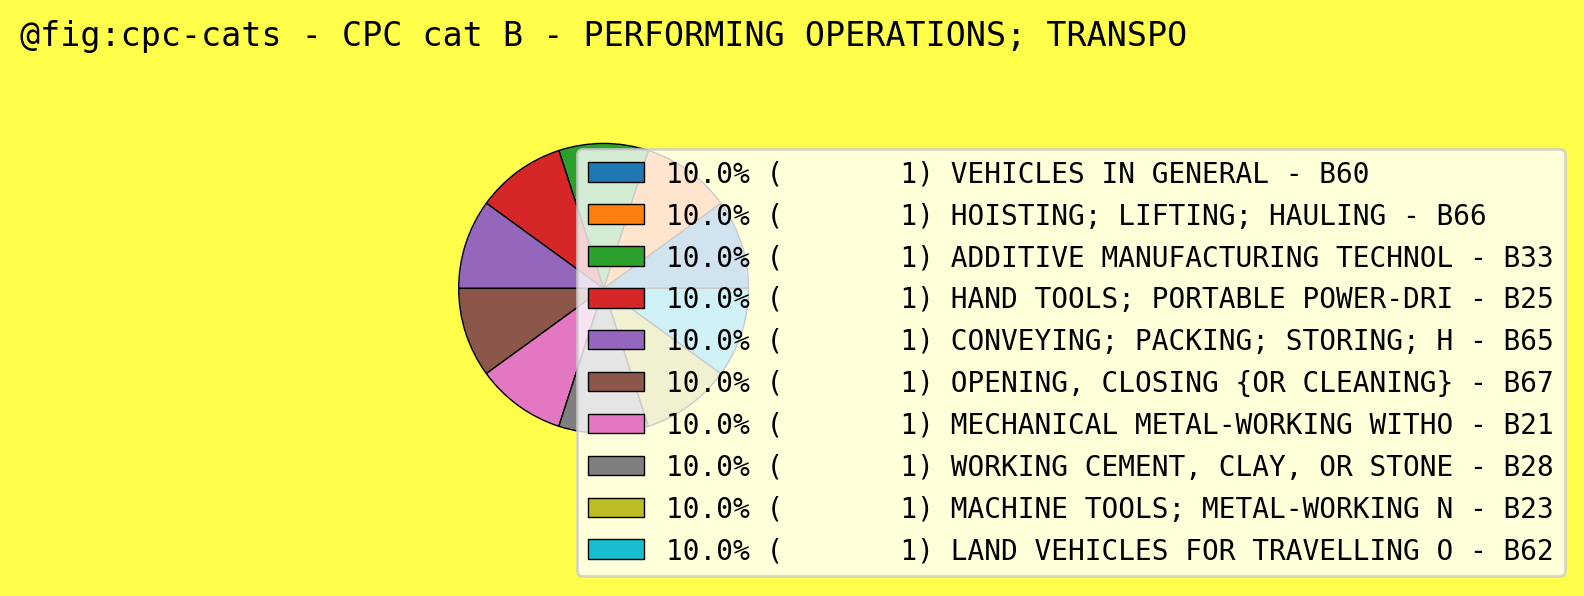

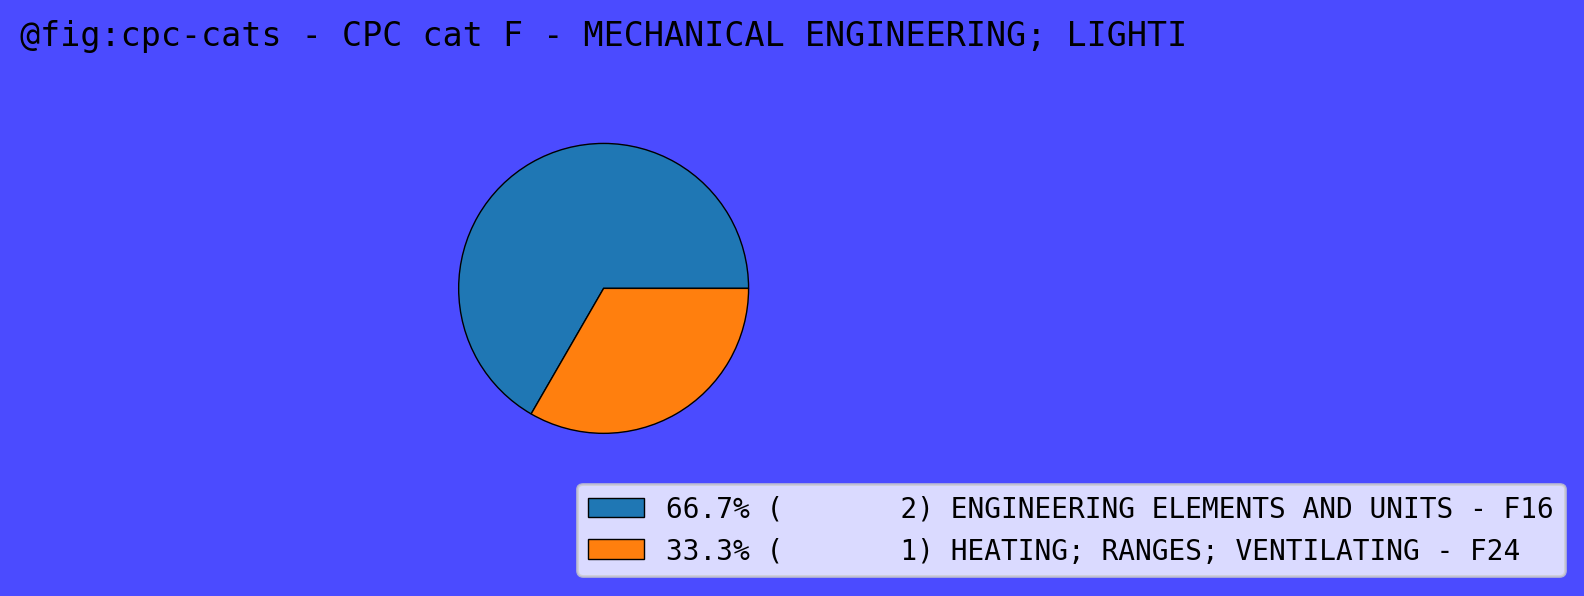

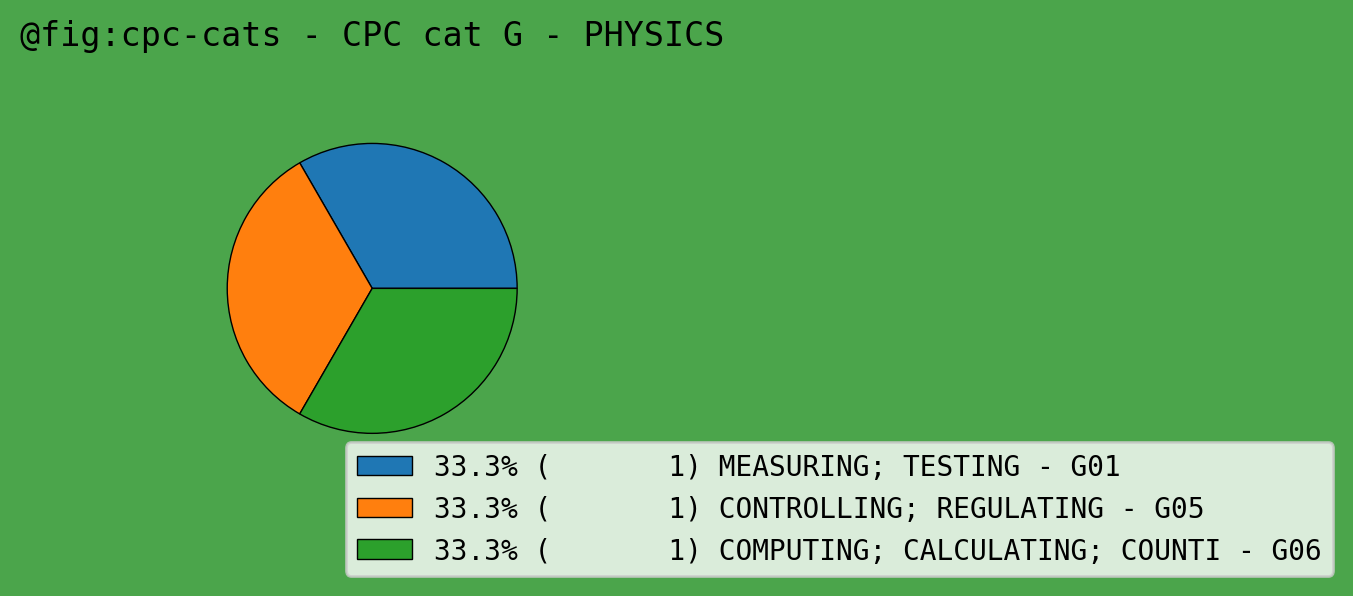

In [12]:
for main in cpc_mains:
    subs = cpc_mains[main]
    x = [ cpc_titles[main + k][:30] + ' - ' + main + re.sub(r'^$', '  ', k) for k in subs.keys() ]
    if len(x) < 2:
        continue
    y = list(subs.values())
    fig_cpcs, ax_cpcs = piechart_create(
        x,
        y,
        title="@fig:cpc-cats - CPC cat " + main + " - " + cpc_titles[main][:30],
        label="Projects",
        legend_vals=True)
    fig_cpcs.patch.set_facecolor(cpc_main_colors[cpc_main2index[main]])
    fig_cpcs.patch.set_alpha(0.7)

In [13]:
labels = []
ids = []
titles = []
values = []
colors = []
for main in cpc_mains:
    subs = cpc_mains[main]
    # ax.bar(cpc_main_keys, vals, width)
    ids += [ main + k for k in subs.keys() ]
    titles += [ cpc_titles[main + k] for k in subs.keys() ]
    labels += [ cpc_titles[main + k][:30] + ' - ' + main + re.sub(r'^$', '  ', k) for k in subs.keys() ]
    # cpc_titles
    values += subs.values()
    colors += [cpc_main_colors[cpc_main2index[main]]] * len(subs)

# y_pos = range(len(values))
# plt.rcdefaults()
# fig, ax = plt.subplots()
# ax.barh(y_pos, values, align='center', color=colors)
# ax.set_yticks(y_pos, labels=labels)
# ax.invert_yaxis() # labels read top-to-bottom
# ax.set_xlabel('Projects')
# ax.set_title('@fig:cpc-sub-cats - CPC sub-categories')
# plt.show()

md_table = """
`@tbl:cpc-legend`

| CPC ID | #Projects | Title |
| --- | --- | --- |
| CPC ID | #Projects | Title |
"""
for i in range(len(values)):
    md_table += "| " + ids[i] + " | " + str(values[i]) + " | " + titles[i] + " |\n"
md(md_table)


`@tbl:cpc-legend`

| CPC ID | #Projects | Title |
| --- | --- | --- |
| CPC ID | #Projects | Title |
| A01 | 1 | AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTING; TRAPPING; FISHING |
| A61 | 1 | MEDICAL OR VETERINARY SCIENCE; HYGIENE |
| A23 | 1 | FOODS OR FOODSTUFFS; TREATMENT THEREOF, NOT COVERED BY OTHER CLASSES |
| A41 | 2 | WEARING APPAREL |
| H04 | 1 | ELECTRIC COMMUNICATION TECHNIQUE |
| H01 | 1 | BASIC ELECTRIC ELEMENTS |
| H02 | 1 | GENERATION; CONVERSION OR DISTRIBUTION OF ELECTRIC POWER |
| H | 15 | ELECTRICITY |
| H05 | 2 | ELECTRIC TECHNIQUES NOT OTHERWISE PROVIDED FOR |
| B60 | 1 | VEHICLES IN GENERAL |
| B66 | 1 | HOISTING; LIFTING; HAULING |
| B33 | 1 | ADDITIVE MANUFACTURING TECHNOLOGY |
| B25 | 1 | HAND TOOLS; PORTABLE POWER-DRIVEN TOOLS; MANIPULATORS |
| B65 | 1 | CONVEYING; PACKING; STORING; HANDLING THIN OR FILAMENTARY MATERIAL |
| B67 | 1 | OPENING, CLOSING {OR CLEANING} BOTTLES, JARS OR SIMILAR CONTAINERS; LIQUID HANDLING |
| B21 | 1 | MECHANICAL METAL-WORKING WITHOUT ESSENTIALLY REMOVING MATERIAL; PUNCHING METAL |
| B28 | 1 | WORKING CEMENT, CLAY, OR STONE |
| B23 | 1 | MACHINE TOOLS; METAL-WORKING NOT OTHERWISE PROVIDED FOR |
| B62 | 1 | LAND VEHICLES FOR TRAVELLING OTHERWISE THAN ON RAILS |
| F16 | 2 | ENGINEERING ELEMENTS AND UNITS; GENERAL MEASURES FOR PRODUCING AND MAINTAINING EFFECTIVE FUNCTIONING OF MACHINES OR INSTALLATIONS; THERMAL INSULATION IN GENERAL |
| F24 | 1 | HEATING; RANGES; VENTILATING |
| G01 | 1 | MEASURING; TESTING |
| G05 | 1 | CONTROLLING; REGULATING |
| G06 | 1 | COMPUTING; CALCULATING; COUNTING |
| C12 | 1 | BIOCHEMISTRY; BEER; SPIRITS; WINE; VINEGAR; MICROBIOLOGY; ENZYMOLOGY; MUTATION OR GENETIC ENGINEERING |
| D03 | 3 | WEAVING |
| Y02 | 1 | TECHNOLOGIES OR APPLICATIONS FOR MITIGATION OR ADAPTATION AGAINST CLIMATE CHANGE |


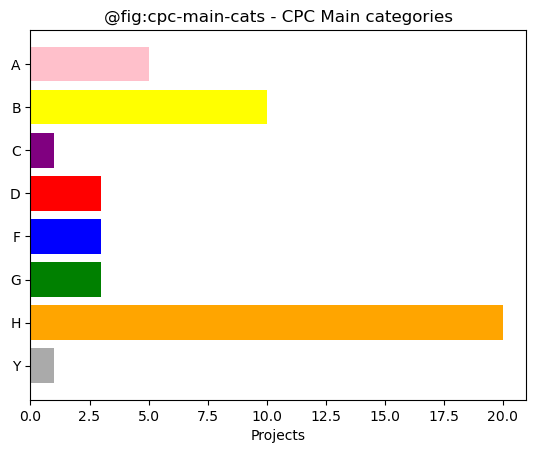

In [14]:
main_labels = list(cpc_mains.keys())
main_labels.sort()
main_colors = [ cpc_main_colors[cpc_main2index[main]] for main in main_labels ]
main_projs = [ sum(cpc_mains[main].values()) for main in main_labels ]

y_pos = range(len(main_labels))
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(y_pos, main_projs, align='center', color=main_colors)
ax.set_yticks(y_pos, labels=main_labels)
ax.invert_yaxis() # labels read top-to-bottom
ax.set_xlabel('Projects')
ax.set_title('@fig:cpc-main-cats - CPC Main categories')
plt.show()

## File Types

- search for MIME types of associated source and export files
- also state for how many projects source files are even defined

**NOTE: From here on, there is no more data, becasue the required fields do not exist.**

# Platform-specific Insights

## OSHWA

The Open Source Hardware Association (OSHWA) runs a certification program for OSH. Certified projects are officially deemed to be fully compliant to the OSHWA definition of OSH ([ref](https://www.oshwa.org/definition/)).

@fig:oshwa-cert-cumul shows the historical development of certificates issued in the past years

In [15]:
# <!-- TODO Robin (NO-CAN-DO: No creation-time data) line plot of cumulated certifications over time (x-axis could be e.g. per quarter, but that's totally optional) -->
# #fig:oshwa-cert-cumul

@fig:oshwa-cert-rate and @fig:oshwa-cert-growth show the derived certification rate and relative growth.

In [16]:
# <!-- TODO Robin (NO-CAN-DO: No creation-time data) line plot of (certifications per year) over time -->
# #fig:oshwa-cert-rate

In [17]:
# <!-- TODO Robin (NO-CAN-DO: No creation-time data) horizontal bar chart with growth of (certifications per year) relative to the year before-->
# #fig:oshwa-cert-growth

A total of {number-of-biggest-OSHWA-licensors-adding-up-to-50%} creators have combined to certify ~50 % of all currently OSHWA-certified projects. So {number-of-biggest-OSHWA-licensors-adding-up-to-50% / oshwa-unique-licensors-total} % of creators make half of OSHWA's database. On the other end we have {number-of-OSHWA-licensors-with-only-1-certificate} holders of a single certificate ( % of all creators). This calculates to a median of nearly {OSHWA-median-certificates-per-licensor} per participating individual or organization.

@fig:oshwa-cert-rate illustrates the distribution of certifications among creators.

In [18]:
# <!-- TODO Robin vertical bar chart with certifications per licensor-->
# #fig:oshwa-cert-rate

Since OSHWA also publishes the location of the certified OSH projects (or rather the corresponding team or organisation, presumingly), we can also see how these certifications distribute among countries, as shown in @fig:oshwa-cert-country and @fig:oshwa-cert-country-map.

In [19]:
# <!-- TODO Robin (NO-CAN-DO: No geo-location data) vertical bar chart with certifications per country -->
# #fig:oshwa-cert-country 

In [20]:
# <!-- TODO Robin (NO-CAN-DO: No geo-location data) world map with certifications per country (see https://i0.wp.com/oshdata.wpcomstaging.com/wp-content/uploads/2020/09/cert-density-by-country.png?resize=768%2C467&ssl=1)-->
# #fig:oshwa-cert-country-map.

<!--- NOTE: the world map is totally optional; if that's to hard to implement → no biggy -->

## Wikifactory

Wikifactory is an online platform dedicated to OSH. It is designed to need specific needs and offer specialised services that arise in the development (and production) process of OSH. The platform itself is not open source, but free to use (however, there are some cool premium features).
It is important to mention that lots of projects on Wikifactory are not open source and hence are not considered in the following statistics.

@fig:wif-proj-hist-cumul illustrates the historical growth of OSH projects on Wikifactory; @fig:wif-proj-tag-cloud shows the most popular tags of those projects in a word cloud.

In [21]:
# <!-- TODO Robin (NO-CAN-DO: No creation-time data) line plot of cumulated project creations over time (`dateCreated`) (x-axis could be e.g. per quarter, but that's totally optional) -->
# #fig:wif-proj-hist-cumul

In [22]:
# <!-- TODO Robin (NO-CAN-DO: No tag data) word cloud of most used tags -->
# #fig:wif-proj-tag-cloud

The following sections aim to give you a feeling for the OSH projects hosted on that platform :)

### Project Locations

Since some users on wikifactory also specify the location of their project, we can also see how those projects distribute among countries, as shown in @fig:wif-proj-country and @fig:wif-proj-country-map.

In [23]:
# <!-- TODO Robin (NO-CAN-DO: No geo-location data) vertical bar chart with projects per country (`createdInRegion`) -->
# #fig:wif-proj-country

In [24]:
# <!-- TODO Robin (NO-CAN-DO: No geo-location data) world map with projects per country (see https://i0.wp.com/oshdata.wpcomstaging.com/wp-content/uploads/2020/09/cert-density-by-country.png?resize=768%2C467&ssl=1)-->
# #fig:wif-proj-country-map

<!--- NOTE: the world map is totally optional; if that's to hard to implement → no biggy -->

### Most Downloaded

It may be safe to say that OSH projects generally aim to be replicated and therewith have relevant applications in practice, improving people's lifes (in whichever way).
An indicator for practical replication of a projects is the number of downloads of its technical documentation.

On average an OSH project on Wikifactory is downloaded {average-archiveDownloadCount-WIF} times; [{name-of-WIF-project-with-most-downloads}]({repoURL-of-WIF-project-with-most-downloads}) is currently the most downloaded project with now totalling {archiveDownloadCount-of-project-with-most-downloads-WIF} downloads.

@fig:wif-downloads-dist shows the distribution of downloads per project, @fig:wif-downloads-top20 the top 20 of most downloaded OSH projects on wikifactory.

In [25]:
# <!-- TODO Robin (NO-CAN-DO: No view data) horizontal bar chart with distribution of downloads per project-->
# #fig:wif-downloads-dist

In [26]:
# <!-- TODO Robin (NO-CAN-DO: No view data) vertical bar chart with top 20 projects with most downloads-->
# #fig:wif-downloads-top20

### Most Viewed

The popularity of open source projects depends on many factors, not only the awesomeness of it's technical solution. Especially for commercialised projects, this may be an important performance indicator; and of course, popular projects may have an easier game when it comes to actual community building.
An indicator for how much attention a project receives is its number of views.

On average an OSH project on Wikifactory is viewed {average-pageviewsCount-WIF} times; [{name-of-WIF-project-with-most-views}]({repoURL-of-WIF-project-with-most-views}) is currently the most viewed project with now totalling {pageviewsCount-of-project-with-most-views-WIF} views.

@fig:wif-views-dist shows the distribution of total views per project, @fig:wif-views-top20 the top 20 of most viewed OSH projects on wikifactory.

In [27]:
# <!-- TODO Robin (NO-CAN-DO: No view data) horizontal bar chart with distribution of total views per project-->
# #fig:wif-views-dist

In [28]:
# <!-- TODO Robin (NO-CAN-DO: No view data) vertical bar chart with top 20 projects with most views-->
# #fig:wif-views-top20 

### Most Contributions

Development on Wikifactory is version-controlled per "contribution" made (sort of equals "commits" on git-based systems).
An indicator for how much development work has been carried out on a single project is its number of contributions.

On average an OSH project on Wikifactory consists of {average-contributionCount-WIF} contributions; [{name-of-WIF-project-with-most-contributions}]({repoURL-of-WIF-project-with-most-contributions}) is currently the project with most contribution with now totalling {contributionCount-of-project-with-most-contributions-WIF} contributions. 

@fig:wif-contributions-dist shows the distribution of total contributions per project, @fig:wif-contributions-top20 the top 20 of OSH projects most contributions on wikifactory.

In [29]:
# <!-- TODO Robin (NO-CAN-DO: No contributors data) horizontal bar chart with distribution of contributions per project-->
# #fig:wif-contributions-dist

In [30]:
# <!-- TODO Robin (NO-CAN-DO: No contributors data) vertical bar chart with top 20 projects with most contributions-->
# #fig:wif-contributions-top20

### Most Contributors

Community is an essential factor for successful open source projects.
An indicator for how wide the developer base of a single project is, is its number of contributors.

On average an OSH project on Wikifactory has {average-contributors-WIF} contributors; [{name-of-WIF-project-with-most-contributors}]({repoURL-of-WIF-project-with-most-contributors}) is currently the project with most contributors with now totalling {contributors-of-project-with-most-contributors-WIF} contributors. 

@fig:wif-contributors-dist shows the distribution of total contributors per project, @fig:wif-contributors-top20 the top 20 of OSH projects most contributors on wikifactory.

In [31]:
# <!-- TODO Robin (NO-CAN-DO: No contributors data) horizontal bar chart with distribution of contributors per project-->
# #fig:wif-contributors-dist

In [32]:
# <!-- TODO Robin (NO-CAN-DO: No contributors data) vertical bar chart with top 20 projects with most contributors-->
# #fig:wif-contributors-top20

In [33]:
# <!-- TODO Robin (NO-CAN-DO: No contributors data) vertical bar chart with top 20 projects with most contributors-->

### Outro

<!--- TODO Moe add brief & friendly outro -->

See also

- https://stateofoshw.oshwa.org/